In [3]:
using ITensors

In [4]:
using Plots

In [5]:
using SparseArrays, LinearAlgebra, Arpack, LsqFit

# 1. J1-J2 spin 1/2 chain

##     1. Heisenberg Hamiltonian construction for finite J2 term

Using

$\vec{S_{i}\cdot}\vec{S}_{j}=S_{i}^{z}S_{j}^{z}+\frac{1}{2}(S_{i}^{+}S_{j}^{-}+S_{i}^{-}S_{j}^{+})$

The hamiltonian gets the form

$ H=J_{1}\sum_{i}\vec{S_{i}\cdot}\vec{S}_{i+1}+J_{2}\sum_{i}\vec{S_{i}}\cdot\vec{S_{i+2}}$

$    =J_{1}\sum_{i}\left(S_{i}^{z}S_{i+1}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+1}^{-}+S_{i}^{-}S_{i+1}^{+})\right)+J_{2}\sum_{i}\left(S_{i}^{z}S_{i+2}^{z}+\frac{1}{2}(S_{i}^{+}S_{i+2}^{-}+S_{i}^{-}S_{i+2}^{+})\right) $

Generalization of the method seen in class 6 for the MPO will lead to the matrices


$W_{(L)}=\left(\begin{array}{c}
I\\
S^{z}\\
S^{+}\\
S^{-}\\
0\\
0\\
0\\
0
\end{array}\right)$

$W_{(i)}=\left(\begin{array}{cccccccc}
I & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{z} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{+} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
S^{-} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & I & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & I & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & I & 0 & 0 & 0 & 0\\
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I
\end{array}\right)$

$W_{(1)}=\left(\begin{array}{cccccccc}
0 & J_{1}S^{z} & \frac{J_{1}}{2}S^{-} & \frac{J_{1}}{2}S^{+} & J_{2}S^{z} & \frac{J_{2}}{2}S^{-} & \frac{J_{2}}{2}S^{+} & I\end{array}\right)$

In [6]:
function J1J2_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1/2", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N
        if j < N
            # Interaction term between neighboring spins (Sz-Sz)
            ampo += J1, "Sz", j, "Sz", j + 1
            ampo += J1/2, "S+", j, "S-", j + 1 
            ampo += J1/2, "S-", j, "S+", j + 1
        end
        if j < N-1
            # Interaction term between second neighboring spins (Sz-Sz)
            ampo += J2, "Sz", j, "Sz", j + 2
            ampo += J2/2, "S+", j, "S-", j + 2 
            ampo += J2/2, "S-", j, "S+", j + 2
        end 
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    #psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    psi0 = MPS(sites,state)
    
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps);

    return energy, psi
end;

## 2. Finite size scaling

In [118]:
function energy_gap_calc(H_func,N_arr,g,swp_num,maxM,base_subspace=0,excited_subspace=1 ; return_states = false)
    delta_arr=[]
    J1=1.
    J2=g*J1
    for N in N_arr
        energy_s0, psi_0 = H_func(N, J1, J2, swp_num, maxM,base_subspace);
        energy_s_excited, psi_excited = H_func(N, J1, J2, swp_num, maxM,excited_subspace);
        push!(delta_arr, energy_s_excited-energy_s0)
    end
    if !return_states
        return delta_arr
    else
        return delta_arr, psi_0, psi_excited
    end
end;

In [8]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100
g_arr=[0 ,0.241, 0.48];

In [9]:
j1j2spin_half_deltas_arr=[]
for g in g_arr
    push!(j1j2spin_half_deltas_arr,energy_gap_calc(J1J2_DMRG,N_arr,g,swp_num,maxM))
end;

After sweep 1 energy=-8.60514183065435  maxlinkdim=4 maxerr=0.00E+00 time=34.946
After sweep 2 energy=-8.681922609869904  maxlinkdim=16 maxerr=0.00E+00 time=1.445
After sweep 3 energy=-8.682473323653621  maxlinkdim=64 maxerr=8.77E-17 time=0.627
After sweep 4 energy=-8.68247333439891  maxlinkdim=99 maxerr=9.81E-17 time=0.230
After sweep 5 energy=-8.682473334398972  maxlinkdim=97 maxerr=1.04E-16 time=0.276
After sweep 6 energy=-8.682473334398976  maxlinkdim=97 maxerr=8.94E-17 time=0.295
After sweep 7 energy=-8.682473334398955  maxlinkdim=97 maxerr=8.94E-17 time=0.285
After sweep 8 energy=-8.682473334398965  maxlinkdim=97 maxerr=8.94E-17 time=0.302
After sweep 9 energy=-8.682473334398964  maxlinkdim=97 maxerr=8.94E-17 time=0.261
After sweep 10 energy=-8.68247333439896  maxlinkdim=97 maxerr=8.94E-17 time=0.266
After sweep 1 energy=-7.910060820117726  maxlinkdim=4 maxerr=0.00E+00 time=0.058
After sweep 2 energy=-8.479555924186457  maxlinkdim=16 maxerr=0.00E+00 time=0.106
After sweep 3 energ

After sweep 10 energy=-44.08729916754671  maxlinkdim=100 maxerr=1.76E-10 time=2.934
After sweep 1 energy=-7.893031868110662  maxlinkdim=4 maxerr=0.00E+00 time=0.282
After sweep 2 energy=-7.94944575912862  maxlinkdim=16 maxerr=0.00E+00 time=0.342
After sweep 3 energy=-7.94978613502113  maxlinkdim=64 maxerr=9.98E-17 time=0.397
After sweep 4 energy=-7.949786241657115  maxlinkdim=100 maxerr=6.60E-16 time=0.619
After sweep 5 energy=-7.949786241662649  maxlinkdim=100 maxerr=2.41E-16 time=0.756
After sweep 6 energy=-7.949786241662642  maxlinkdim=100 maxerr=1.70E-16 time=0.615
After sweep 7 energy=-7.949786241662626  maxlinkdim=100 maxerr=1.70E-16 time=0.568
After sweep 8 energy=-7.949786241662648  maxlinkdim=100 maxerr=1.70E-16 time=0.505
After sweep 9 energy=-7.949786241662641  maxlinkdim=100 maxerr=1.70E-16 time=0.532
After sweep 10 energy=-7.949786241662631  maxlinkdim=100 maxerr=1.70E-16 time=0.442
After sweep 1 energy=-7.267425336676245  maxlinkdim=4 maxerr=0.00E+00 time=0.055
After swee

After sweep 9 energy=-40.06545406548293  maxlinkdim=100 maxerr=8.84E-11 time=5.762
After sweep 10 energy=-40.06553217396506  maxlinkdim=100 maxerr=5.58E-11 time=5.089
After sweep 1 energy=-7.49616712208073  maxlinkdim=4 maxerr=0.00E+00 time=0.088
After sweep 2 energy=-7.503861902049232  maxlinkdim=16 maxerr=0.00E+00 time=0.149
After sweep 3 energy=-7.503869774420087  maxlinkdim=64 maxerr=7.84E-17 time=0.236
After sweep 4 energy=-7.503869788818607  maxlinkdim=100 maxerr=3.64E-16 time=0.376
After sweep 5 energy=-7.503869788823641  maxlinkdim=91 maxerr=2.01E-16 time=0.457
After sweep 6 energy=-7.503869788823639  maxlinkdim=86 maxerr=9.98E-17 time=0.430
After sweep 7 energy=-7.503869788823646  maxlinkdim=86 maxerr=9.94E-17 time=0.370
After sweep 8 energy=-7.503869788823656  maxlinkdim=86 maxerr=9.94E-17 time=0.376
After sweep 9 energy=-7.503869788823648  maxlinkdim=86 maxerr=9.94E-17 time=0.407
After sweep 10 energy=-7.503869788823638  maxlinkdim=86 maxerr=9.94E-17 time=0.501
After sweep 1

After sweep 8 energy=-37.30391943337031  maxlinkdim=100 maxerr=4.45E-11 time=4.791
After sweep 9 energy=-37.30837316989935  maxlinkdim=100 maxerr=6.28E-11 time=5.560
After sweep 10 energy=-37.31212928522433  maxlinkdim=100 maxerr=8.88E-11 time=7.495


In [16]:
function plot_delta_energies(deltas,N_array,g; plot_fit=true)
    x = 1 ./ N_array
    fun(x, a) = a[1] .+ a[2]*x
    res = LsqFit.curve_fit(fun, x, deltas, [0., 0.]);
    plt=scatter(x, deltas,linestyle = :dot,title="Energy deltas g=$g",xlabel="1/N",ylabel= "Delta")
    if plot_fit
        plot!(plt,x, fun(x, coef(res)))
        intercept=coef(res)[1]
        println("The intercept for g=0 is $intercept")
    end
    return plt
end;

For g=0:

The intercept for g=0 is 0.006985882985487524


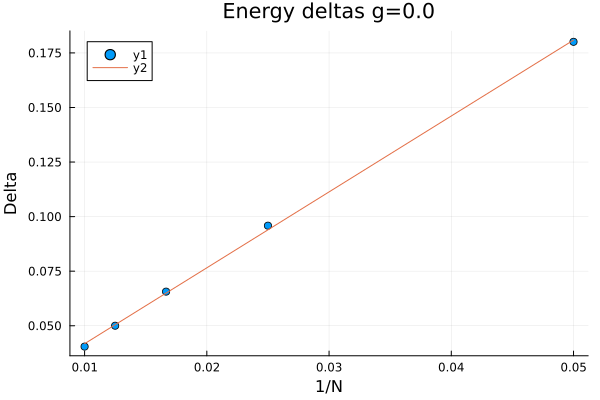

In [17]:
i=1
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i])

Which is pretty close to zero, indicating the system is gapless as expected

For g=g_c=0.241

The intercept for g=0 is 0.003511926213340998


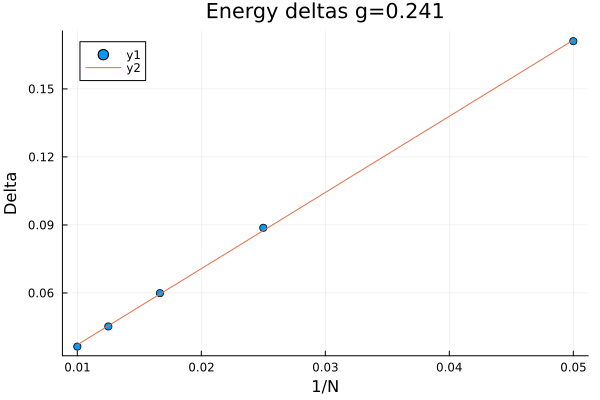

In [18]:
i=2
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i])

Which is pretty close to zero, indicating the system is gapless as expected for still being in the phase with g below gc

For g=0.48:

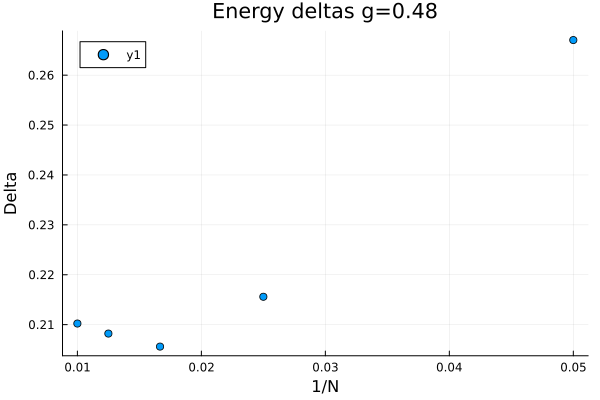

In [19]:
i=3
plot_delta_energies(j1j2spin_half_deltas_arr[i],N_arr,g_arr[i],plot_fit=false)

Here we can see an obvious finite gap as expected from being deep in the dimerized phase. The trend of the points indicates an intercept with the y axis which is non-zero.

## 3. Spin-spin correlations

In [63]:
function plot_SzSz_correlations(corr_mat, x_array, g , plot_fit_type="power_law")
    N = x_array[end]
    
    """
    #x = x_array[100:end] .- 100
    #y= log10.(abs.(corr_mat[100,100:end]))
    x = 1 ./ (x_array[101:end] .- 100)
    y = abs.(corr_mat[100,101:end])
    """
    x = x_array[101:end] .- 100
    y = abs.(corr_mat[100,101:end])
    plt=scatter(x,y,xlabel="x-100",ylabel="Sₓ₀⃗⋅Sₓ⃗",title="Spin correlations for g=$g",label="correlations")
    if plot_fit_type=="power_law"
        fun_power(x, a) = a[1] ./ (x .^ a[2])
        res = LsqFit.curve_fit(fun_power, x, y, [100.,1.]);
        plot!(x , fun_power(x, coef(res)),label="fit")
        α_g=coef(res)[2]
        println("The exponent α for g=$g was found from the fit to be $α_g")
    end
    if plot_fit_type=="exp_law"
        fun_exp(x, a) = a[1]*exp.(-x./a[2])
        res = LsqFit.curve_fit(fun_exp, x, y, [0.,1.]);
        plot!(x , fun_exp(x, coef(res)),label="fit")
        α_g=coef(res)[2]
        println("The exponent α for g=$g was found from the fit to be $α_g")
    end
    return plt
end;

In [21]:
N = 200
x_array= [x for x in 1:N];
swp_num = 10
maxM = 100
J1=1.0;
g_array=[0 ,0.241, 0.48];

In [22]:
corr_mats=[]
for g in g_array
    energy, psi = J1J2_DMRG(N,1., g, swp_num, maxM ,0)
    push!(corr_mats, correlation_matrix(psi,"Sz","Sz"))
end

After sweep 1 energy=-87.90732132925154  maxlinkdim=4 maxerr=0.00E+00 time=0.504
After sweep 2 energy=-88.40009736494895  maxlinkdim=16 maxerr=0.00E+00 time=1.112
After sweep 3 energy=-88.4367923683276  maxlinkdim=64 maxerr=9.54E-17 time=1.887
After sweep 4 energy=-88.44026222450567  maxlinkdim=100 maxerr=3.54E-11 time=4.092
After sweep 5 energy=-88.4412149980951  maxlinkdim=100 maxerr=3.27E-10 time=6.098
After sweep 6 energy=-88.44152457900702  maxlinkdim=100 maxerr=2.73E-09 time=5.235
After sweep 7 energy=-88.44155419065386  maxlinkdim=100 maxerr=3.52E-09 time=5.368
After sweep 8 energy=-88.44155471067545  maxlinkdim=100 maxerr=2.85E-09 time=6.150
After sweep 9 energy=-88.44155471372999  maxlinkdim=100 maxerr=2.80E-09 time=5.304
After sweep 10 energy=-88.44155471369858  maxlinkdim=100 maxerr=2.81E-09 time=5.143
After sweep 1 energy=-79.85921543022567  maxlinkdim=4 maxerr=0.00E+00 time=0.641
After sweep 2 energy=-80.26699841583698  maxlinkdim=16 maxerr=0.00E+00 time=1.500
After sweep 

For g=0:

The exponent α for g=0.0 was found from the fit to be 0.9747021126405984


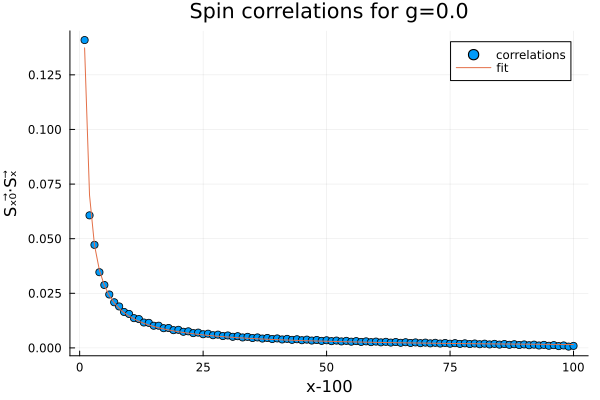

In [56]:
i=1
plt=plot_SzSz_correlations(corr_mats[i], x_array, g_array[i])

For g=g_c=0.241

The exponent α for g=0.241 was found from the fit to be 1.1334176605526294


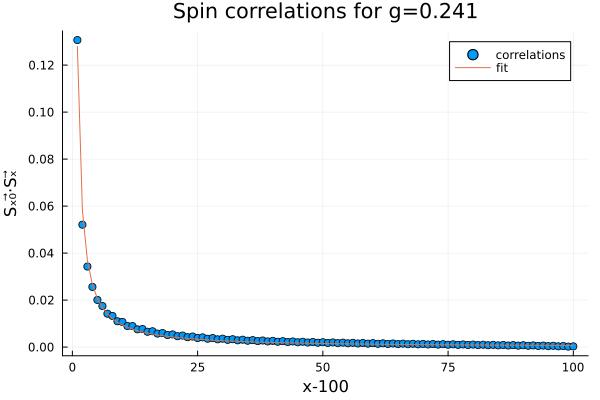

In [57]:
i=2
plot_SzSz_correlations(corr_mats[i], x_array, g_array[i])

For g=0.48:

The exponent α for g=0.48 was found from the fit to be 1.8987928552306337


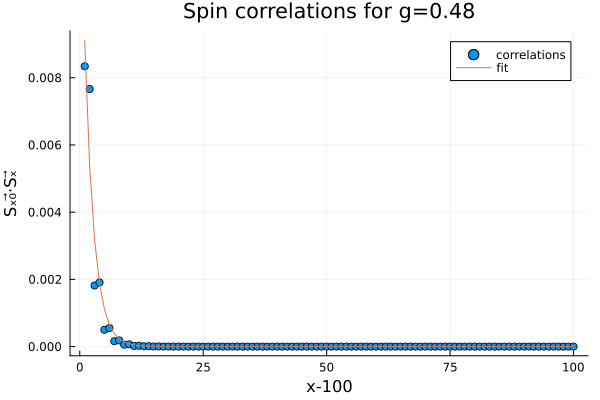

In [64]:
i=3
plot_SzSz_correlations(corr_mats[i], x_array, g_array[i],"exp_law")

# 2. spin-1 - Haldane gap

In [99]:
function bilinear_biquadtatic_DMRG(N::Int64, J1::Float64, J2::Float64, swp_num::Int64, maxM::Int64, QN_subspace::Int64)
    
    # Generate an index set representing quantum sites with spin S=1/2
    sites = siteinds("S=1", N; conserve_qns=true)

    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the TFIM
    for j = 1:N-1
        # Interaction term between neighboring spins (Sz-Sz)
        ampo += J1, "Sz", j, "Sz", j + 1
        ampo += J1/2, "S+", j, "S-", j + 1
        ampo += J1/2, "S-", j, "S+", j + 1
        
        #J2 
        ampo += J2, "Sz", j, "Sz", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S-", j, "S+", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S+", j, "S-", j + 1, "S+", j, "S-", j + 1
        ampo += J2/4, "S-", j, "S+", j + 1, "S-", j, "S+", j + 1
        ampo += J2/2, "S-", j, "S+", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/2, "S+", j, "S-", j + 1, "Sz", j, "Sz", j + 1
        ampo += J2/2, "Sz", j, "Sz", j + 1, "S-", j, "S+", j + 1
        ampo += J2/2, "Sz", j, "Sz", j + 1, "S+", j, "S-", j + 1
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)

    # Initialize the initial state to a random maxM=10 state 
    # psi0 = randomMPS(sites,10)
    state= [isodd(n) ? "Up" : "Dn" for n=1:N]
    if QN_subspace == 1
        state[2]="Up"
    end
    if QN_subspace == 2
        state[2]="Up"
        state[4]="Up"
    end
    psi0 = MPS(sites,state)
    # Set up parameters for the DMRG (Density Matrix Renormalization Group) algorithm
    sweeps = Sweeps(swp_num)
    setmaxdim!(sweeps, maxM)
    setcutoff!(sweeps, 1E-16)

    # Perform the DMRG simulation to obtain the ground state energy and MPS representation
    energy, psi = dmrg(H, psi0, sweeps)

    return energy, psi
end;

## 1. System gap for J2 between 0 and 1/3

In [67]:
N_arr= [ n for n in 20:20:100];
swp_num = 10
maxM = 100;

In [68]:
J2_arr=[ j for j in 0:1/12:1/3];

In [106]:
deltas_arr=[]
for g in J2_arr
    push!(deltas_arr,energy_gap_calc(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,0,2))
end;

After sweep 1 energy=-26.75638798881602  maxlinkdim=9 maxerr=0.00E+00 time=0.144
After sweep 2 energy=-26.828056595029913  maxlinkdim=79 maxerr=8.78E-17 time=0.331
After sweep 3 energy=-26.83029331381671  maxlinkdim=100 maxerr=5.16E-10 time=0.635
After sweep 4 energy=-26.833623190738706  maxlinkdim=100 maxerr=1.05E-09 time=0.656
After sweep 5 energy=-26.83753390916417  maxlinkdim=100 maxerr=2.34E-09 time=0.774
After sweep 6 energy=-26.839437495110868  maxlinkdim=100 maxerr=2.69E-09 time=0.689
After sweep 7 energy=-26.839907332615596  maxlinkdim=100 maxerr=3.74E-09 time=0.656
After sweep 8 energy=-26.839972031795604  maxlinkdim=100 maxerr=5.91E-09 time=0.712
After sweep 9 energy=-26.83997807919772  maxlinkdim=100 maxerr=2.27E-09 time=0.644
After sweep 10 energy=-26.839978567153093  maxlinkdim=100 maxerr=7.26E-10 time=0.615
After sweep 1 energy=-20.119505903566736  maxlinkdim=9 maxerr=0.00E+00 time=0.065
After sweep 2 energy=-23.569873063013812  maxlinkdim=81 maxerr=4.51E-17 time=0.279
A

After sweep 10 energy=-137.39900680838696  maxlinkdim=100 maxerr=5.24E-09 time=4.978
After sweep 1 energy=-22.998796096796468  maxlinkdim=9 maxerr=0.00E+00 time=0.125
After sweep 2 energy=-23.046826549391092  maxlinkdim=78 maxerr=9.31E-17 time=0.503
After sweep 3 energy=-23.047100886268854  maxlinkdim=100 maxerr=8.25E-11 time=1.137
After sweep 4 energy=-23.047442836572483  maxlinkdim=100 maxerr=1.45E-10 time=1.187
After sweep 5 energy=-23.048123180033038  maxlinkdim=100 maxerr=2.27E-10 time=1.140
After sweep 6 energy=-23.049263654809963  maxlinkdim=100 maxerr=3.23E-10 time=1.266
After sweep 7 energy=-23.05039129550728  maxlinkdim=100 maxerr=5.89E-10 time=1.197
After sweep 8 energy=-23.05093750671484  maxlinkdim=100 maxerr=5.20E-10 time=1.257
After sweep 9 energy=-23.05107585292633  maxlinkdim=100 maxerr=3.37E-10 time=1.184
After sweep 10 energy=-23.0511018183303  maxlinkdim=100 maxerr=3.09E-10 time=1.238
After sweep 1 energy=-16.791093993881958  maxlinkdim=9 maxerr=0.00E+00 time=0.095


After sweep 9 energy=-117.80465955401571  maxlinkdim=100 maxerr=2.61E-09 time=8.776
After sweep 10 energy=-117.84974564298982  maxlinkdim=100 maxerr=5.02E-09 time=8.724
After sweep 1 energy=-19.383915149749974  maxlinkdim=9 maxerr=0.00E+00 time=0.141
After sweep 2 energy=-19.409761192481984  maxlinkdim=78 maxerr=9.99E-17 time=0.517
After sweep 3 energy=-19.4097848632376  maxlinkdim=100 maxerr=2.79E-12 time=1.179
After sweep 4 energy=-19.40979438748053  maxlinkdim=100 maxerr=5.34E-12 time=1.332
After sweep 5 energy=-19.409809982056814  maxlinkdim=100 maxerr=8.13E-12 time=1.205
After sweep 6 energy=-19.40984191331785  maxlinkdim=100 maxerr=1.24E-11 time=1.221
After sweep 7 energy=-19.40991437919027  maxlinkdim=100 maxerr=1.59E-11 time=1.330
After sweep 8 energy=-19.41000866031231  maxlinkdim=100 maxerr=2.67E-11 time=1.296
After sweep 9 energy=-19.410101724787808  maxlinkdim=100 maxerr=3.10E-11 time=1.283
After sweep 10 energy=-19.410186974204105  maxlinkdim=100 maxerr=3.43E-11 time=1.256

After sweep 8 energy=-98.30245025038451  maxlinkdim=100 maxerr=2.40E-09 time=8.811
After sweep 9 energy=-98.9698170909342  maxlinkdim=100 maxerr=7.26E-08 time=8.796
After sweep 10 energy=-99.0044440550682  maxlinkdim=100 maxerr=8.05E-10 time=9.766
After sweep 1 energy=-15.930106346650668  maxlinkdim=9 maxerr=0.00E+00 time=0.131
After sweep 2 energy=-15.940668680408622  maxlinkdim=80 maxerr=9.98E-17 time=0.463
After sweep 3 energy=-15.940672366092132  maxlinkdim=100 maxerr=1.11E-13 time=1.200
After sweep 4 energy=-15.94067238178582  maxlinkdim=100 maxerr=4.39E-14 time=1.221
After sweep 5 energy=-15.94067239960304  maxlinkdim=100 maxerr=6.69E-14 time=1.138
After sweep 6 energy=-15.940672418971937  maxlinkdim=100 maxerr=8.65E-14 time=1.304
After sweep 7 energy=-15.94067243900955  maxlinkdim=100 maxerr=9.99E-14 time=1.208
After sweep 8 energy=-15.940672459733015  maxlinkdim=100 maxerr=1.43E-13 time=1.293
After sweep 9 energy=-15.940672481331518  maxlinkdim=100 maxerr=2.17E-13 time=1.218
Af

After sweep 7 energy=-80.08368200668599  maxlinkdim=100 maxerr=5.99E-10 time=9.075
After sweep 8 energy=-80.13654250340768  maxlinkdim=100 maxerr=9.00E-10 time=8.856
After sweep 9 energy=-80.1797632802232  maxlinkdim=100 maxerr=8.92E-10 time=8.805
After sweep 10 energy=-80.2158375746058  maxlinkdim=100 maxerr=1.52E-09 time=8.901
After sweep 1 energy=-12.66449118031143  maxlinkdim=9 maxerr=0.00E+00 time=0.135
After sweep 2 energy=-12.66666497602683  maxlinkdim=69 maxerr=9.86E-17 time=0.445
After sweep 3 energy=-12.666666661023013  maxlinkdim=100 maxerr=1.42E-15 time=1.015
After sweep 4 energy=-12.666666666647679  maxlinkdim=68 maxerr=9.98E-17 time=0.871
After sweep 5 energy=-12.666666666666583  maxlinkdim=12 maxerr=9.94E-17 time=0.315
After sweep 6 energy=-12.666666666666671  maxlinkdim=2 maxerr=8.81E-17 time=0.099
After sweep 7 energy=-12.666666666666668  maxlinkdim=2 maxerr=2.94E-21 time=0.117
After sweep 8 energy=-12.666666666666664  maxlinkdim=2 maxerr=6.77E-26 time=0.061
After swee

After sweep 7 energy=-62.874953950453076  maxlinkdim=100 maxerr=3.69E-09 time=6.489
After sweep 8 energy=-62.9077989470637  maxlinkdim=100 maxerr=1.39E-09 time=5.344
After sweep 9 energy=-62.93504100885935  maxlinkdim=100 maxerr=9.99E-10 time=3.702
After sweep 10 energy=-62.96241905186622  maxlinkdim=100 maxerr=2.59E-09 time=3.328


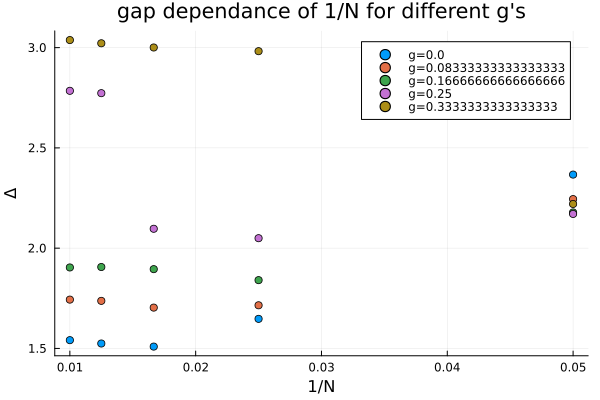

In [113]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = deltas_arr[i]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for different g's",label="g=$g",xlabel="1/N",ylabel= "Δ")
for i in 2:5
    g=J2_arr[i]
    y = deltas_arr[i]
    scatter!(x, y,linestyle = :dot,label="g=$g")
end
scatter!()

We see that for all J2 between 0 and 1/3 the energy gap is finite and non zero.

### 2.a Energy gaps between the ground states of S=0 and S=1 subspaces. For J2 between 0 and 1/3

In [119]:
s0s1_res_arr=[]
for g in J2_arr
    push!(s0s1_res_arr,energy_gap_calc(bilinear_biquadtatic_DMRG,N_arr,g,swp_num,maxM,0,1;return_states=true))
end;

After sweep 1 energy=-26.75638798881602  maxlinkdim=9 maxerr=0.00E+00 time=0.213
After sweep 2 energy=-26.828056595029913  maxlinkdim=79 maxerr=8.78E-17 time=0.698
After sweep 3 energy=-26.83029331381671  maxlinkdim=100 maxerr=5.16E-10 time=0.935
After sweep 4 energy=-26.833623190738706  maxlinkdim=100 maxerr=1.05E-09 time=0.817
After sweep 5 energy=-26.83753390916417  maxlinkdim=100 maxerr=2.34E-09 time=0.692
After sweep 6 energy=-26.839437495110868  maxlinkdim=100 maxerr=2.69E-09 time=0.786
After sweep 7 energy=-26.839907332615596  maxlinkdim=100 maxerr=3.74E-09 time=0.837
After sweep 8 energy=-26.839972031795604  maxlinkdim=100 maxerr=5.91E-09 time=0.696
After sweep 9 energy=-26.83997807919772  maxlinkdim=100 maxerr=2.27E-09 time=0.686
After sweep 10 energy=-26.839978567153093  maxlinkdim=100 maxerr=7.26E-10 time=0.671
After sweep 1 energy=-24.148917750350922  maxlinkdim=9 maxerr=0.00E+00 time=0.079
After sweep 2 energy=-26.119141743021096  maxlinkdim=81 maxerr=9.43E-17 time=0.368
A

After sweep 10 energy=-138.50434294406858  maxlinkdim=100 maxerr=2.59E-09 time=5.086


LoadError: UndefVarError: `psi_0` not defined

In [120]:
s0s1_res_arr

Any[]

In [109]:
i=1
g=J2_arr[i]
x = 1 ./ N_arr
y = s0s1_res_arr[i][1]

scatter(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta");
for i in 2:5
    g=J2_arr[i]
    y = s0s1_res_arr[i][1]
    scatter!(x, y,linestyle = :dot,title="gap dependance of 1/N for g=$g",xlabel="1/N",ylabel= "Delta")
end
scatter!()

LoadError: Cannot convert Float64 to series data for plotting

### 2.b Local expectation value of Sz along the chain

In [110]:
function plot_and_talk_about_Sz_expectation(expectation_Sz,g)
    p=plot(expectation_Sz_arr[gst_index],xlabel="i",ylabel="⟨Sz⟩",title="g=$g ⟨Sz⟩'s across the chain")
    left=expectation_Sz_arr[gst_index][1]
    right=expectation_Sz_arr[gst_index][end]
    sum_5_left=sum([expectation_Sz_arr[gst_index][i] for i in 1:5])
    sum_5_right=sum([expectation_Sz_arr[gst_index][end-i+1] for i in 1:5])
    println("For g=$g")
    println("The spin values at the edges are- Left=$left Right=$right")
    println("The spin sum of 5 nearest to the edges are- Left=$sum_5_left Right=$sum_5_right")
    return p
end;

In [111]:
for i,g in enumerate(J2_arr)
    plot_and_talk_about_Sz_expectation(expect(s0s1_res_arr[i][3], "Sz"),g)
end

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///home/nativ/many_body/hw3-DMRG/In[111]#1:6\[90mIn[111]:1:6[0;0m]8;;\
for i[48;2;120;70;70m[0;0m,g in enumerate(J2_arr)
[90m#    └ ── [0;0m[91minvalid iteration spec: expected one of `=` `in` or `∈`[0;0m